## Import Libraries

In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Import Datasets

In [124]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [125]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [126]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names

### Sort columns by the attributes 'id' and 'cycle'

In [127]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'

In [128]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)


### Normalize test data in all columns that are different to 'id' and 'cycle'

In [129]:
norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [130]:
# Create a column for the RUL
rul = pd.DataFrame(train_data.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_data = train_data.merge(rul, on=['id'], how='left')
train_data['RUL'] = train_data['max'] - train_data['cycle']
train_data.drop('max', axis=1, inplace=True)

# Create a column for the RUL
rul = pd.DataFrame(test_data.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
test_data = test_data.merge(rul, on=['id'], how='left')
test_data['RUL'] = test_data['max'] - test_data['cycle']
test_data.drop('max', axis=1, inplace=True)



In [131]:
# Remove columns with only one unique value
train_data = train_data.loc[:, train_data.apply(pd.Series.nunique) != 1]
test_data = test_data.loc[:, test_data.apply(pd.Series.nunique) != 1]

# Fill missing values with the mean
train_data = train_data.fillna(train_data.mean())

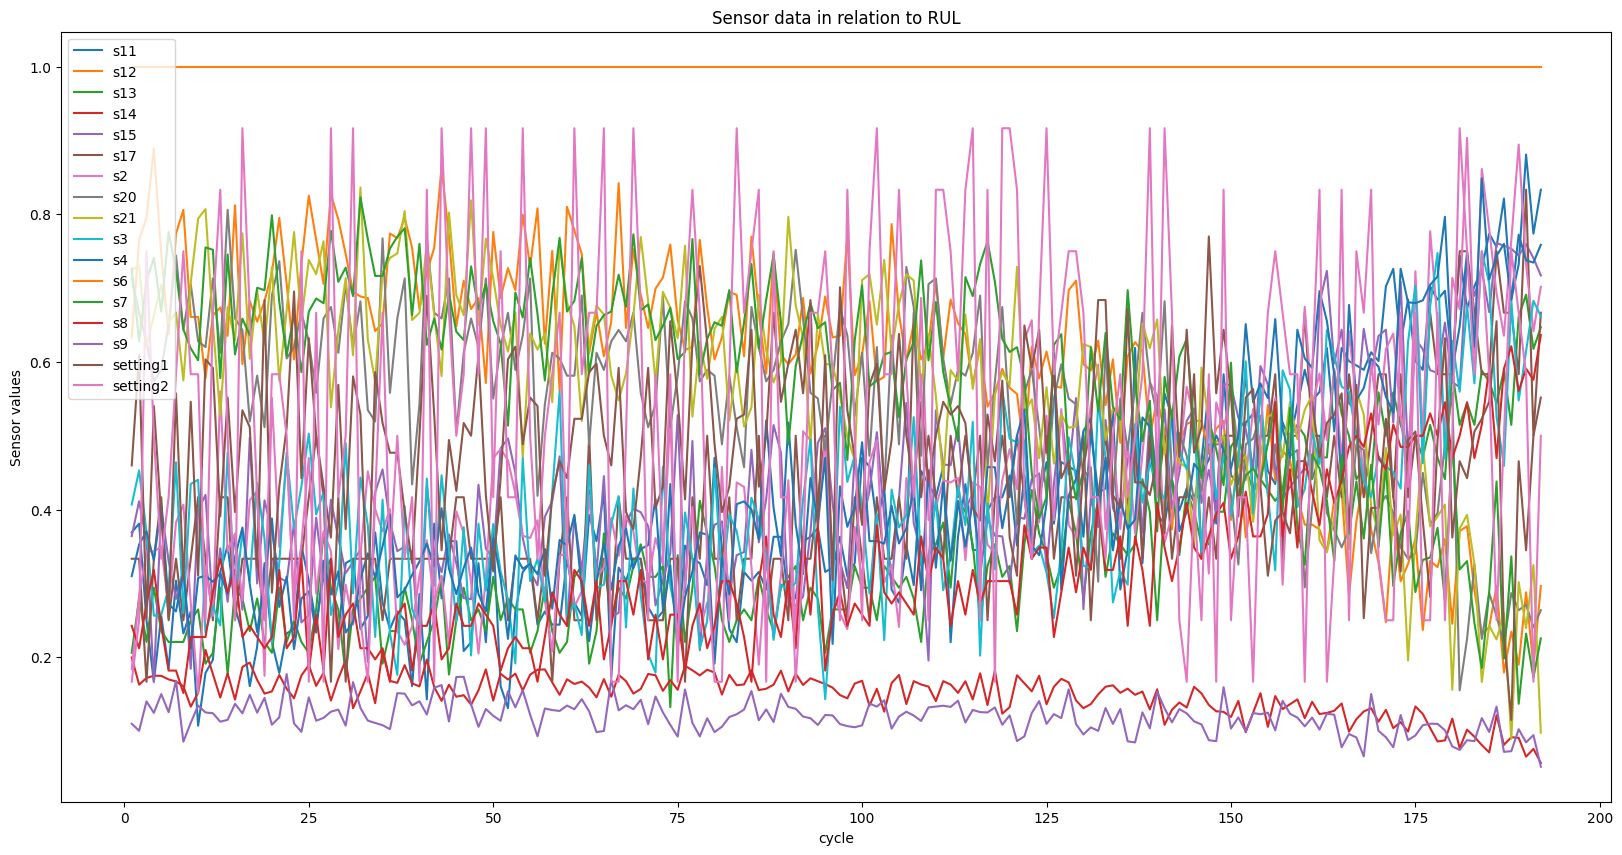

In [132]:
# EDA
# Plot Sensor data in relation to cycles
plt.figure(figsize=(20, 10))

# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL']):
    plt.plot(train_data[train_data["id"] == 1]["cycle"], train_data[i][train_data["id"] == 1], label=i)

plt.xlabel('cycle')
plt.ylabel('Sensor values')
plt.title('Sensor data in relation to RUL')
plt.legend()
plt.show()



In [138]:
# Prepare data for training
if 'RUL' in train_data.columns and 'RUL' in test_data.columns and 'id' in train_data.columns and 'id' in test_data.columns and 'cycle' in train_data.columns and 'cycle' in test_data.columns:
    train_data = train_data.drop(['id', 'cycle'], axis=1)
    test_data = test_data.drop(['id', 'cycle'], axis=1)

    y_train = train_data['RUL']
    y_test = test_data['RUL']
    
    X_train = train_data.drop('RUL', axis=1)
    X_test = test_data.drop('RUL', axis=1)
    
# Train Neural Network
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


In [137]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
RMSE: 92.56239944847871
MAE: 75.85202873919533
R2: -2.0437207221984863
